## Background
Globally, 1 in 71 children contract pneumonia every year. Unfortunately, pediatric pneumonia is also frequently fatal resulting in an estimated 2,200 deaths per day worldwide. To diagnose pediatric pneumonia, highly skilled physicians such as pediatric radiologists are needed to interpret the medical imaging. However, the distribution of these providers is highly disparate globally.

## Business Problem
Countries with few pediatric radiologists per capita may have potentially higher risks of delays in diagnosis and corresponding treatment failures. Higher costs and interventional risks may also be worsened. Thus, our team endeavored to produce a diagnostic support tool, leveraging machine learning to speed and improve diagnosis of pediatric pneumonia. We believe our diagnostic support tool will be particularly useful in helping healthcare providers in countries with few pediatric radiologists per capita.

## Data Understanding
We used 5224 pediatric chest xrays to develop a diagnostic support tool that can differentiate between a normal chest xray (CXR) and a chest xray in a pediatric patient with pneumonia. There were 1341 normal CXR, 3883 pneumonia CXR. Recall was the metric of choice as failure to properly diagnose pneumonia (or false negative) could potentially be fatal to the child. Using recall allows us to try to reduce these false negatives.

## Modeling
We used a convolutional neural network (CNN) to developed our diagnostic support tool as they’re good for image classification. CNNs are particularly strong when for image classification especially wehn geared towards color images.

In [1]:
# Importing libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense
from keras.models import Model
from keras.metrics import Recall

In [2]:
# Instantiating ImageDataGenerator and normalizing the RGB values
traingen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
testgen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
valgen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# Creating training data generator
train_data = traingen.flow_from_directory(
    # Specifying location of training data
    directory='data_split/train',
    # Re-sizing images to 100x100
    target_size=(100, 100),
    # Class mode to binary to recoginize the two directories "Normal" and "PNA" as the labels
    class_mode='binary',
    batch_size=15,
    seed=16
)
# Creating testing data generator
test_data = testgen.flow_from_directory(
    # Specifying location of testing data
    directory='data_split/test',
    # Re-sizing images to 100x100
    target_size=(100, 100),
    # Class mode to binary to recoginize the two directories "Normal" and "PNA" as the labels
    class_mode='binary',
    batch_size=15,
    seed=16
)

# Creating validation set
val_data = valgen.flow_from_directory(
    # Specifying location of testing data
    directory='data_split/val',
    # Re-sizing images to 100x100
    target_size=(100, 100),
    # Class mode to binary to recoginize the two directories "Normal" and "PNA" as the labels
    class_mode='binary',
    batch_size=15,
    seed=16
)

Found 5224 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [3]:
# Putting image classification into a dataframe
classes = pd.DataFrame(train_data.classes)
values = classes.value_counts()

In [4]:
classes

,0
0,0
1,0
2,0
3,0
4,0
...,...
5219,1
5220,1
5221,1
5222,1


In [5]:
# Giving the data binary labels to allow for visialization of class imbalance below.
class_dict = {0:'Normal', 1:'PNA'}
classes[0] = classes[0].map(class_dict)

In [6]:
image_interpretation = classes[0].value_counts()
image_interpretation

PNA       3883
Normal    1341
Name: 0, dtype: int64

In [7]:
classes[0].value_counts(normalize=True)

PNA       0.7433
Normal    0.2567
Name: 0, dtype: float64

In [8]:
image_interpretation.index

Index(['PNA', 'Normal'], dtype='object')

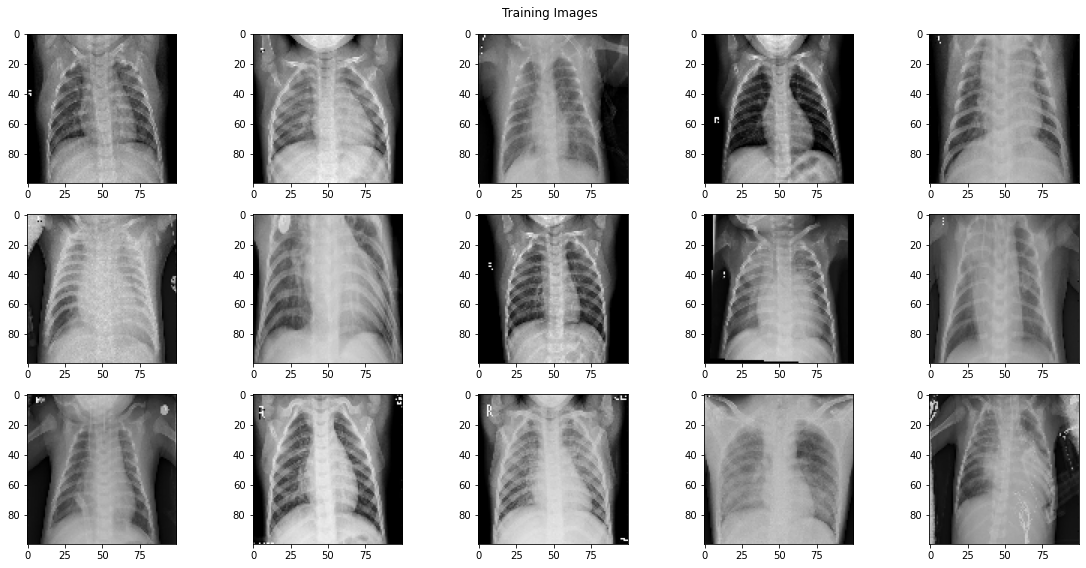

In [9]:
# Visualize
train_batch = train_data.next()
fig, axes = plt.subplots(3, 5, figsize=(16, 8))
    
for i in range(15):
    # Load image into numpy array and re-scale
    img = np.array(train_batch[0][i] * 255, dtype='uint8')
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
fig.suptitle('Training Images')
plt.tight_layout()
plt.show()

### Baseline Model
Essentially a logistic regression model with a single node output layer using a sigmoid activation function and 1 epocs.

In [10]:
model_0 = keras.Sequential(
    [   keras.Input(shape=(100,100,3)), 
        keras.layers.Flatten(), 
        keras.layers.Dense(1, activation="sigmoid"),
    ])
model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 30000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 30001     
Total params: 30,001
Trainable params: 30,001
Non-trainable params: 0
_________________________________________________________________


In [11]:
model_0.compile(loss='binary_crossentropy',
              metrics=[keras.metrics.Recall()])

In [12]:
model_0.fit(train_data, epochs=1, batch_size=15, validation_data=(test_data))

349/349 [==============================] - 74s 212ms/step - loss: 1.4392 - recall: 0.8548 - val_loss: 0.7427 - val_recall: 0.9769


### Model 1
Added a 10 node hidden layer, continuing sigmoid activation function, an rmsprop optimizer, and 3 epochs.

In [13]:
model_1 = keras.Sequential(
    [   keras.Input(shape=(100,100,3)),
        keras.layers.Dense(10, activation="sigmoid"),
        keras.layers.Flatten(),
        keras.layers.Dense(1, activation="sigmoid"),
    ])
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100, 100, 10)      40        
_________________________________________________________________
flatten_1 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 100001    
Total params: 100,041
Trainable params: 100,041
Non-trainable params: 0
_________________________________________________________________


In [14]:
model_1.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
              metrics=[keras.metrics.Recall()])

In [15]:
model_1.fit(train_data, epochs=3, batch_size=15, validation_data=(test_data))

Epoch 1/3
349/349 [==============================] - 75s 214ms/step - loss: 9.1711 - recall_1: 0.7291 - val_loss: 14.8582 - val_recall_1: 1.0000
Epoch 2/3
349/349 [==============================] - 75s 216ms/step - loss: 4.6510 - recall_1: 0.7783 - val_loss: 6.5233 - val_recall_1: 0.0077
Epoch 3/3
349/349 [==============================] - 73s 210ms/step - loss: 2.1519 - recall_1: 0.8581 - val_loss: 0.6637 - val_recall_1: 0.8256


## Conclusions
Given recent events, including a global pandemic that frequently resulted in pneumonia for those affected and overwhelmed healthcare resources, having a diagnostic support tool to accelerate diagnosis without adding strain to hospital staff is of enormous value. Our diagnostic support tool accurately identifies pediatric pneumonia 95% of the time. We think our diagnostic support tool could be particularly valuable in underserviced communities around the world where pediatric radiologists are scarce.

## Future Considerations
With more time and data we believe our diagnostic support tool can be further improved and may be applicable for evaluation of adult chest xrays. We also plan to refine our model toaccurately differentiate between bacterial and viral pneumonia. Additionally, incorporation clinical data, such vitals signs and blood lab tests, shoulder further improve our diagnostic support tool.